# 1> Importing Necessary Libraries

In [47]:
#Importing Torch libraries
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.0+cpu
torchvision version: 0.20.0+cpu


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print(f"[INFO] Installing torch info")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  print("1")
  from going_modular import data_setup,engine
  from going_modular.helper_functions import download_data,set_seeds,plot_loss_curves
except:
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
  ! git clone https://github.com/mrdbourke/pytorch-deep-learning
  ! mv pytorch-deep-learning/going_modular .
  ! mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  ! rm -rf pytorch-deep-learning
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

1


# 2> Device Agnostic Code

In [49]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


# 3> Get Data

In [50]:
image_path=download_data(source="https://github.com/HarshEkbote/PyTorch-Basics/raw/main/data/pizza_steak_sushi.zip",destination="pizza_steak_sushi")

image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [51]:
train_dir=image_path/"train"
test_dir=image_path/"test"

# 4> Create Dataloaders

In [52]:
#Create transformations
IMG_SIZE=224

manual_transforms=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manual Transforms: {manual_transforms}")

Manual Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [53]:
#Set the batch size
BATCH_SIZE=32    # The batch size is 4096 for the original paper but as our data is small and we use a single GPU we take batch size of 32

#Create Dataloader
train_dataloader,test_dataloader,class_names=data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x26ca941bf70>,
 ['pizza', 'steak', 'sushi'])

torch.Size([3, 224, 224]) tensor(0)


(-0.5, 223.5, 223.5, -0.5)

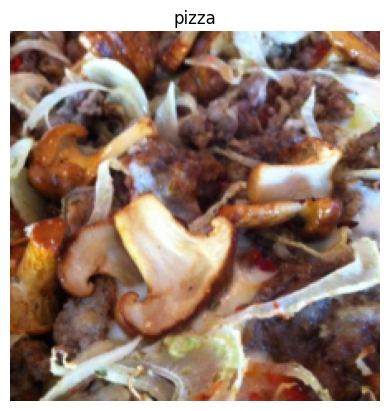

In [54]:
#Visualize the image

#Get the batch of the image
image_batch,label_batch=next(iter(train_dataloader))

#Get the single image from the batch
image,label=image_batch[0],label_batch[0]

print(image.shape,label)

#Plot the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

*Implementing the 4 main equation fot Vit-Base*

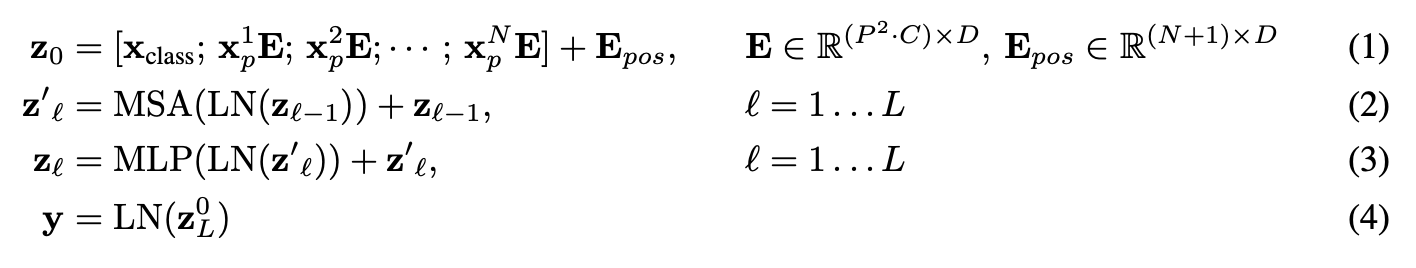

## Equation 1 consists of the following:

1. Divide the image into patches and convert it to embeddings.
2. Create embedding for the class token.
3. Position embedding for each patch.

# 5> Equation 1: Split data into patches and creating the class, position and patch embedding

- Number of patches (N)= (height*width)/ (patch_size^2)
- The image gets converted to a sequence of flattened 2D patches with size (N , P^2 *C)


In [55]:
#creating example values
height=224  #H
width=224 #W
channels=3  #C
patch_size=16 #P

#finding the number of patches for the image size (224,224,3)
number_of_patches=int((height*width)/patch_size**2)
print(f"Number of patches (N) with image (H={height}, W={width}, C={channels} and P={patch_size}): {number_of_patches}")

Number of patches (N) with image (H=224, W=224, C=3 and P=16): 196


In [56]:
#Input shape of the image
embedding_layer_input_shape=(height,width,channels)

#Output shape
embedding_layer_output_shape=(number_of_patches,patch_size**2*channels)
print(f"Input shape: {embedding_layer_input_shape}")
print(f"Output shape: {embedding_layer_output_shape}")

Input shape: (224, 224, 3)
Output shape: (196, 768)


## 5.1> Turning a single image to patches ( manually )

(-0.5, 223.5, 223.5, -0.5)

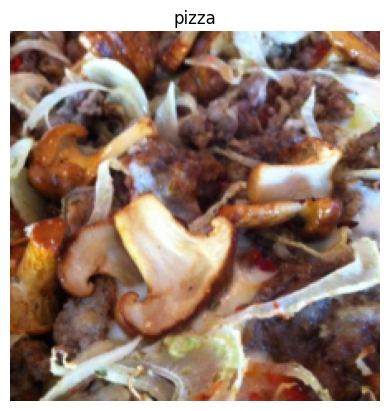

In [57]:
#plotting an image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

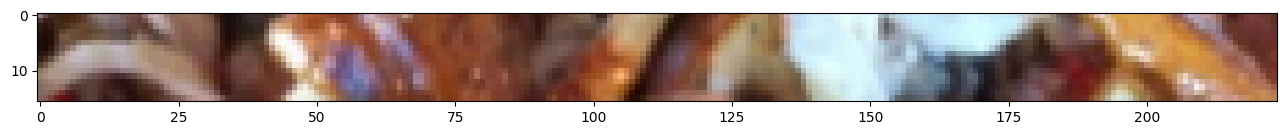

In [58]:
#change image shape to a compatiable with matplotlib
image_permuted=image.permute(1,2,0)

#index to plot the top row of the patches pixels
patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch Size: 16 pixels x 16 pixels


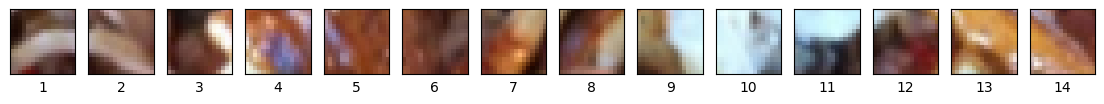

In [59]:
#Patch for only the first row in the image

#setup hyperparameters and make sure img_size and input_size are compatiable
img_size=224
patch_size=16
number_patches=img_size/patch_size
assert img_size%patch_size==0
print(f"Number of patches per row: {number_patches}\nPatch Size: {patch_size} pixels x {patch_size} pixels")

#create a series of subplots
fig,axes=plt.subplots(nrows=1,
                     ncols=img_size//patch_size,
                     figsize=(number_patches,number_patches),
                     sharex=True,
                     sharey=True)

for i, patch in enumerate(range(0,img_size,patch_size)):
  axes[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


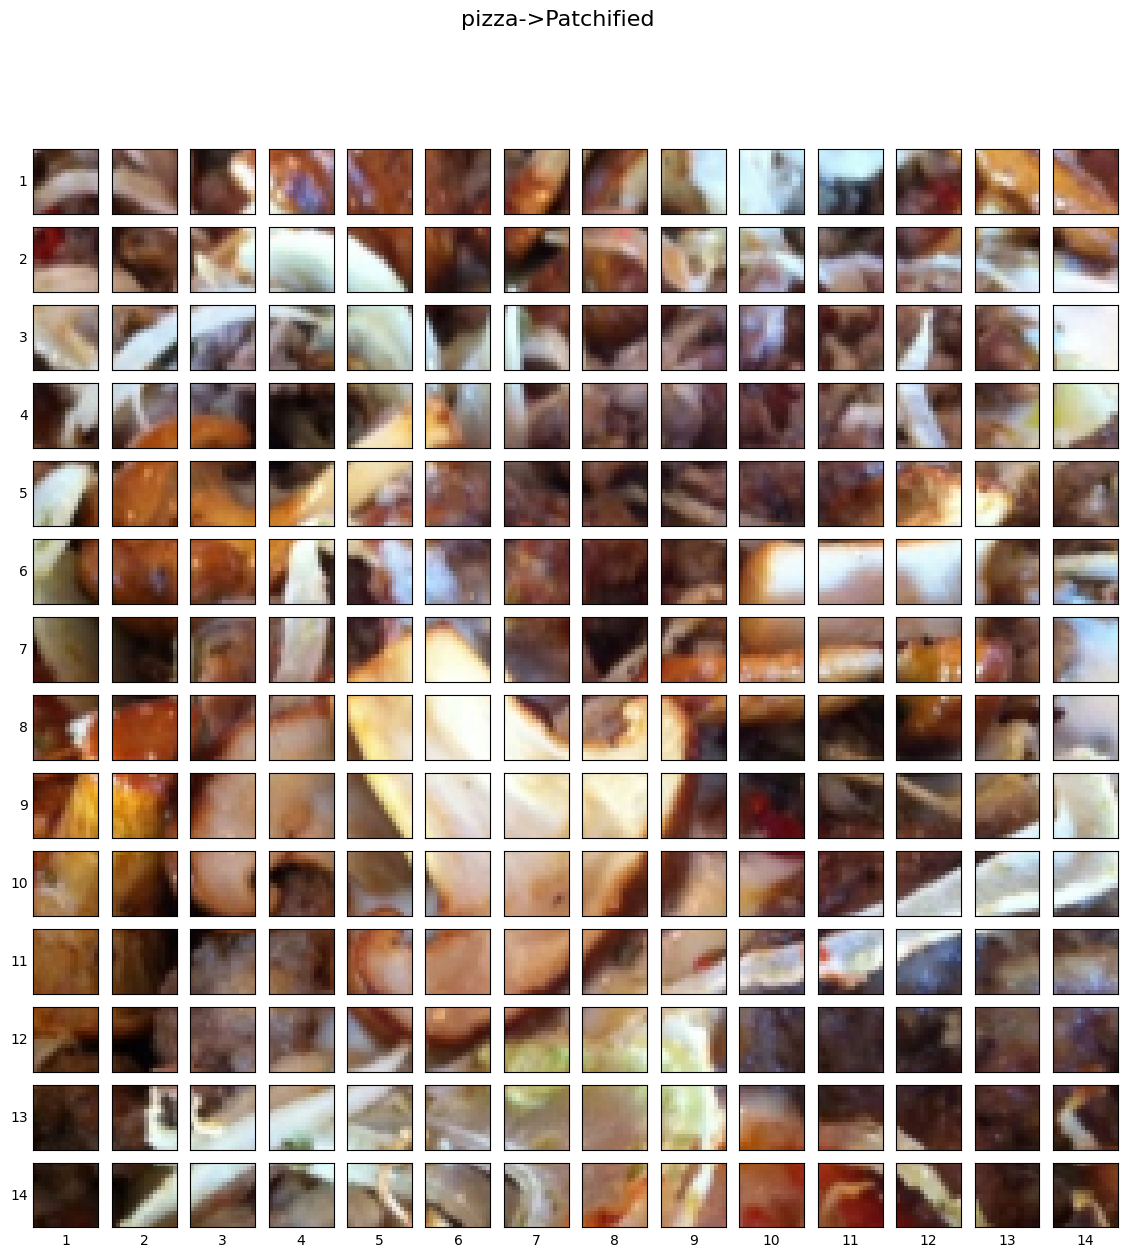

In [60]:
#Patch for the whole image

img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig,axs=plt.subplots(nrows=img_size//patch_size,
                     ncols=img_size//patch_size,
                     figsize=(num_patches,num_patches),
                     sharex=True,
                     sharey=True)

for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):

    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])

    axs[i,j].set_ylabel(i+1,rotation="horizontal",horizontalalignment="right",verticalalignment="center")

    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

#Set super title
fig.suptitle(f"{class_names[label]}->Patchified", fontsize=16)
plt.show()

## 5.2> Creating Patches and embeddings using the Conv2d and flatten fucntions

In [61]:
from torch import nn

#set the patch_size=16
patch_size=16

#create the conv2d layer with hyperparameters from the ViT paper
conv2d=nn.Conv2d(in_channels=3,
                 out_channels=768,
                 kernel_size=patch_size,
                 stride=patch_size,padding=0)

#pass the image through the conv layer
image_out_of_conv=conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)  #[batch_size,embeddings_dim,feature_map_height,feature_map_width]

torch.Size([1, 768, 14, 14])


The random convolutional fetaire maps from index: [572, 574, 142, 520, 723]


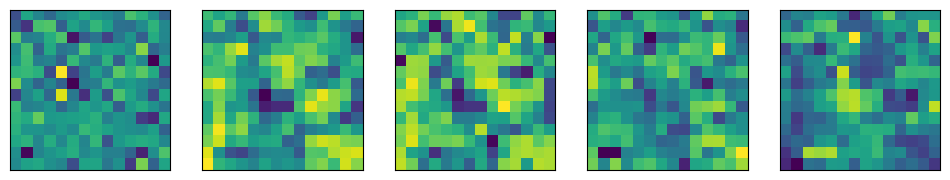

In [62]:
#Visualize random 5 patches
import random
random_index=random.sample(range(0,758),k=5)
print(f"The random convolutional fetaire maps from index: {random_index}")

fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i,idx in enumerate(random_index):
  image_conv_feature_map=image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [63]:
#get a single feature map in tensor form
single_feature_map=image_out_of_conv[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[-2.2182e-01, -2.1425e-01, -1.1948e-01, -2.5412e-01, -8.1987e-02,
           -2.5023e-02, -4.9295e-02, -2.2588e-02,  3.8686e-03, -3.8390e-01,
            3.5048e-02,  3.7972e-02, -5.2992e-02, -2.2919e-01],
          [-4.1080e-01, -2.1982e-01, -3.0419e-01, -1.9400e-01, -4.6965e-01,
            9.6179e-03, -3.2748e-02,  5.9508e-02, -2.3975e-01,  8.7269e-02,
           -3.3716e-01, -2.2656e-01, -2.8601e-01, -4.8733e-01],
          [-3.0962e-01, -1.7278e-01, -1.1565e-02,  1.4370e-01, -1.4298e-01,
           -3.2879e-01, -2.4647e-01, -8.2171e-02, -3.3106e-01, -1.5346e-01,
           -1.4250e-01, -2.5099e-01, -4.7982e-02, -4.1722e-01],
          [ 4.2600e-02, -4.1884e-02, -1.3047e-01,  1.7135e-02, -2.6378e-01,
           -1.0022e-01, -1.2236e-01, -7.0408e-02, -7.9440e-03, -5.4476e-02,
           -3.6731e-02, -2.2286e-01, -2.8544e-01, -9.1267e-02],
          [-4.0576e-01, -6.0288e-02, -2.0856e-01, -2.3984e-01,  1.8780e-02,
           -9.6868e-03, -1.3603e-01, -2.3375e-02, -1.9096e-0

In [64]:
#Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape}") # we need a shape of (768,196)

Current tensor shape: torch.Size([1, 768, 14, 14])


In [65]:
#create flatten layer
flatten=nn.Flatten(start_dim=2, #flatten feature_map_height (dimension 2)
                   end_dim=3)   #flatten feature_map_width  (dimension 3)

## 5.3> Patch the image and convert to emebeddings
1. Take a single image
2. Put in through the conv layer to turn the image into 2D feature map (patch embeddings)
3. Flatten the 2D feature map into a single sequence

Desired output shape is (196,768)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape :torch.Size([1, 768, 14, 14])
Feature image deature map shape (after flatten): torch.Size([1, 768, 196])


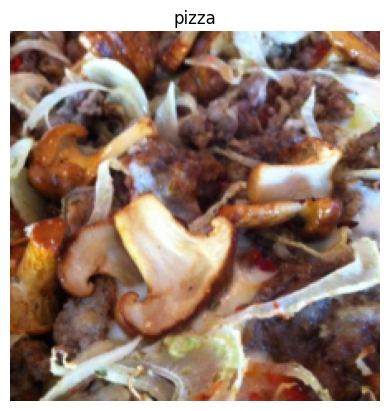

In [66]:
#1. View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

#2. Turn image into feature map
image_out_of_conv=conv2d(image.unsqueeze(0))
print(f"Image feature map shape :{image_out_of_conv.shape}")

#Flatten the feature map
image_flatten=flatten(image_out_of_conv)
print(f"Feature image deature map shape (after flatten): {image_flatten.shape}")

In [67]:
# Putting it to the right shape
image_flat_reshape=image_flatten.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_flat_reshape.shape}->[batch_size,num_patches,embeddings_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768])->[batch_size,num_patches,embeddings_size]


(-0.5, 195.5, 0.5, -0.5)

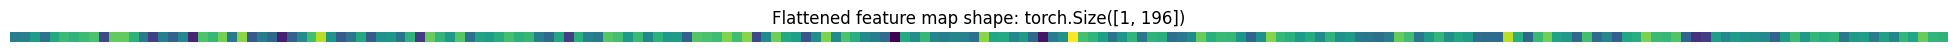

In [68]:
#Visualize te flatten feature map
single_flattened_feature_map=image_flat_reshape[:,:,0]

plt.figure(figsize=(25,25))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [69]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-2.2182e-01, -2.1425e-01, -1.1948e-01, -2.5412e-01, -8.1987e-02,
          -2.5023e-02, -4.9295e-02, -2.2588e-02,  3.8686e-03, -3.8390e-01,
           3.5048e-02,  3.7972e-02, -5.2992e-02, -2.2919e-01, -4.1080e-01,
          -2.1982e-01, -3.0419e-01, -1.9400e-01, -4.6965e-01,  9.6179e-03,
          -3.2748e-02,  5.9508e-02, -2.3975e-01,  8.7269e-02, -3.3716e-01,
          -2.2656e-01, -2.8601e-01, -4.8733e-01, -3.0962e-01, -1.7278e-01,
          -1.1565e-02,  1.4370e-01, -1.4298e-01, -3.2879e-01, -2.4647e-01,
          -8.2171e-02, -3.3106e-01, -1.5346e-01, -1.4250e-01, -2.5099e-01,
          -4.7982e-02, -4.1722e-01,  4.2600e-02, -4.1884e-02, -1.3047e-01,
           1.7135e-02, -2.6378e-01, -1.0022e-01, -1.2236e-01, -7.0408e-02,
          -7.9440e-03, -5.4476e-02, -3.6731e-02, -2.2286e-01, -2.8544e-01,
          -9.1267e-02, -4.0576e-01, -6.0288e-02, -2.0856e-01, -2.3984e-01,
           1.8780e-02, -9.6868e-03, -1.3603e-01, -2.3375e-02, -1.9096e-01,
          -5.1528e-02, -1

## 5.4> Creating a module for the Patch and embedding layer

In [70]:
#1. creating a class
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
  def __init__(self,in_channels:int=3,patch_size:int=16,embedding_size=768):
    super().__init__()

    self.patcher=nn.Conv2d(in_channels=in_channels,out_channels=embedding_size,kernel_size=patch_size,stride=patch_size,padding=0) #layer to turn images to patches

    self.flatten=nn.Flatten(start_dim=2,end_dim=3) #layer to flatten the patch feature maps in single dimension

  def forward(self,x):
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size==0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

  #perform forward pass
    x_patched=self.patcher(x) #make patches for image
    x_flatten=self.flatten(x_patched) #flatten the patches
    return x_flatten.permute(0,2,1) #adjust the shape to (batch_size, N,P^2 * C)

In [71]:
set_seeds()

patchify=PatchEmbedding(in_channels=3,patch_size=16,embedding_size=768)

#pass image through it
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image=patchify(image.unsqueeze(0))
print(f"Output shape of embeddings: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output shape of embeddings: torch.Size([1, 196, 768])


In [72]:
#Summary for the PatchEmbedding Layer

# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17